In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [56]:
# sns.set(font_scale=1.5)

In [57]:
data = pd.read_csv('./Data/resd_features.csv')

In [58]:
data.head()

,surface,n_bhk,sa1,pool,sa9,sa7,sa2,sa5,price
0,-1.082437,1.0,0,1,0,0,1,0,3.9
1,-0.331565,2.0,0,1,0,0,1,0,6.5
2,-0.025358,3.0,0,1,0,0,1,0,7.4
3,0.318126,3.0,0,1,0,0,1,0,8.9
4,-0.414108,2.0,0,1,0,0,0,0,7.4


In [59]:
X = data.iloc[:,:-1]
y = data['price']

### MLPRegession with scikit-learn

In [60]:
def grid_search_report(estimator, X, y, pg, cv=LeaveOneOut(), rs=118):
    """ 
    Performs the grid search and cross validation for the given regressor.
    Params:
      estimator: the regressor
      X: Pandas dataframe, feature data
      y: Pandas series, target data
      pg: dict, parameter grid
      cv: int, cross-validation generator or an iterable, cross validation folds
      rs: int, training-test split random state
    Returns:
      the estimator with the best hyper parameters. Those that give the minimum validation score.
    """
    t0 = time()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

    est_cv = GridSearchCV(estimator=estimator, param_grid=pg, scoring='r2', cv=cv, n_jobs=-1)
    est_cv.fit(X_train, y_train)

    print('Best parameters:', est_cv.best_params_)
    print('Best CV score:', abs(est_cv.best_score_))
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) 
    print('MSE, R2 train:', mean_squared_error(y_train, y_train_pred), r2_score(y_train, y_train_pred))
    print('MSE, R2 test:', mean_squared_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))

    t = round(time() - t0, 2)
    print('Elapsed time:', t, 's ,', round(t/60, 2), 'min' )

    return est_cv

In [61]:
def plot_residue(estimator, X, y, rs=118):
    """ 
    Plots the fit residuals (price - predicted_price) vs. 'surface' variable.
    Params:
      estimator: GridSearchCV, the regressor
      X: Pandas dataframe, feature data
      y: Pandas series, target
      rs: int, random state
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    residue_train = y_train.values.reshape(-1, 1) - estimator.predict(X_train.values).reshape(-1, 1)
    residue_test = y_test.values.reshape(-1, 1) - estimator.predict(X_test.values).reshape(-1, 1)


    fig, axe = plt.subplots(1, 2, figsize=(18, 10))
    axe[0].scatter( X_train['surface'], residue_train, label='train')
    axe[0].scatter( X_test['surface'], residue_test, label='test')
    axe[0].plot( [-2.3, 4.5], [0, 0], 'black')
    axe[0].set_xlabel('Scaled surface')
    axe[0].set_ylabel('Fit residuals')
    axe[0].legend()

    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel('Fit residual for test set')
    axe[1].set_ylabel('Count')
    plt.show()

    print('mean residuals:', round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))

<b>Hyperparameters Explanation:</b>

<ul>
  <li><b>activation='relu'</b> - If the linear combination of the features is negative, relu returns zero, otherwise it acts as an identity function and returns the value of the linear combination of the features.</li>
  <li> <b>solver='adam'</b> - Strategy to compute gradient descent, adam is a stochastic gradient descent technique that accelerates the meaning process.</li>
  <li><b>learning_rate</b> - is the intitial coefficient to update the weight, it is multiplied by the gradient of the loss fucntion with respect to the given weight.</li>
  <li>
  <b>max_iter</b> - Is the maximum number of epochs or iterations over the training set to minimize the loss function.</li> 
  <li><b>early_stopping</b>: True - Stops learning early if loss rate doesn't decrease.</li>
  <li><b>n_iter_no_change</b>: 30 - # iterations with no improve in loss function this is after 30.</li>
  <li><b>tol</b> - Loss function decrease, if loss function doesn't decrease more then tol after n training epochs, the training stops.</li>
  <li><b>validation_fraction</b> - Is a part of the training set put aside to validate the training set.
 <li><b>random_state</b> - Random seed for several random processes (weights, validation set, batch samples)</li>
</ul>

<b>Parameter grid Explanation:</b>

<ul>
  <li><b>hidden_layer_sizes</b> - Should be given in tuple format, size of the tuple gives the number of hidden layers and each element of the tuple gives the number of nodes of the corresponding layer.</li>
  <li><b>learning_rate</b> - Constant learning will keep the initial learning rate, invscaling gradually decreases the learning at each number of epoch, adaptive keeps the learning constant to learning rate init and long as the training loss keeps decreasing otherwise it divides the learning rate by 5. </li>
  <li><b>alpha</b> - Is the regularization term equivalent to Ridge Regession </li>
  <li><b>batch_size</b> - used when applying a stochastic optimizer like Adam, this means for each epoch we divide the training set to n batches and update the weights over each batch.</li>
</ul>

In [62]:
rs = 10

mlpReg = MLPRegressor(activation='relu', solver='adam', 
                     learning_rate_init=0.005, max_iter=1000,
                     early_stopping=True, n_iter_no_change=30,
                     tol=1.e-3, validation_fraction=0.1, random_state=rs)

pg = {
  'hidden_layer_sizes':[(5,), (10,), (5, 5), (10, 3)],
  'learning_rate':['constant', 'invscaling', 'adaptive'],
  'alpha': np.logspace(-3, 3, 10),
  'batch_size': [8, 16, 32,]
}

mlpReg_cv = grid_search_report(mlpReg, X, y, pg, cv=5, rs=rs)

Best parameters: {'alpha': 0.021544346900318832, 'batch_size': 16, 'hidden_layer_sizes': (10, 3), 'learning_rate': 'constant'}
Best CV score: 0.7392813236693124
MSE, R2 train: 8.411389815084648 0.7920153656111567
MSE, R2 test: 4.384130246870555 0.7728364545647043
Elapsed time: 23.72 s , 0.4 min


<b>Obeservations:</b>

R2 for training is slighly larger then that of CV which means model is slightly overfitted, but is not that significant

<b>PLots:</b>

First plot -If there is a correlation between fit residual and any feature like surface, this means the linear model<br>
is not the best model describing the data 

Second plot is the distribution of the fit residual of the test data.<br>
If the distribution is significantly deviated from Guassian, it means the residuals are not white noises<br>
and they are correlated, that is an indication of non-linearity of the data.

/Users/diegosabajo/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/diegosabajo/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


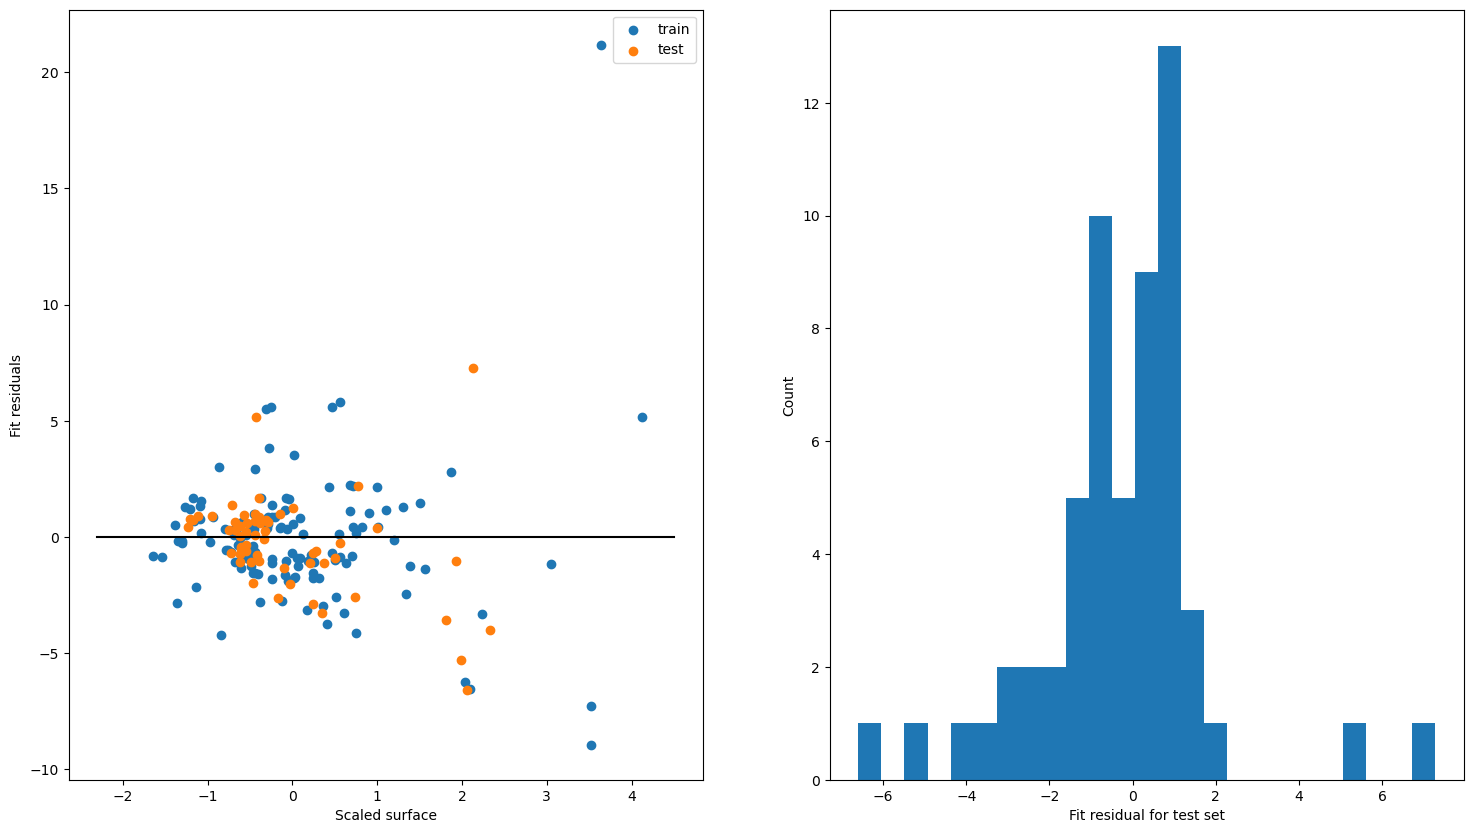

mean residuals: -0.29 
std: 2.07


In [63]:
plot_residue(mlpReg_cv, X, y, rs=rs)

In [64]:
def plot_real_pred(est, X, y, rs):
    """ 
    Plots the real price vs. predicted price.
    Params:
      est: the regressor
      X: Pandas dataframe, feature data
      y: Pandas series, target data
      rs: int, random state
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

    fig = plt.figure(figsize=(7, 7))
    plt.scatter(y_test, est.predict(X_test))
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c='r')
    plt.xlabel('Real price')
    plt.ylabel('Predicted price')
    plt.show()

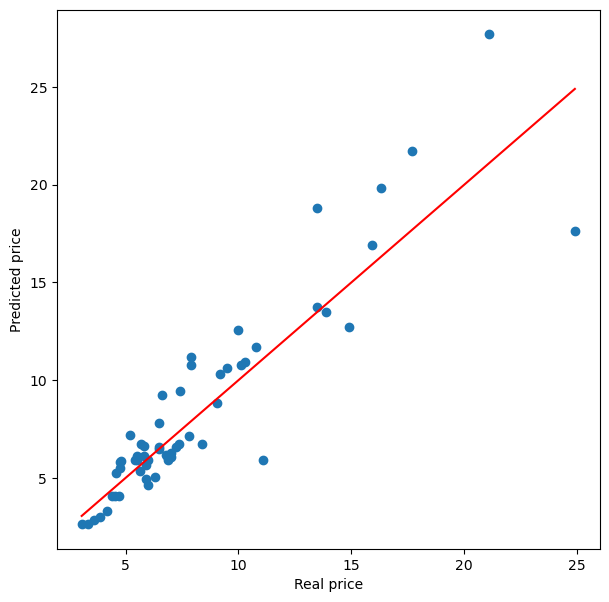

In [65]:
plot_real_pred(mlpReg_cv, X, y, rs=rs)

### Regression with TensorFlow

In [66]:
# defiing a function to make laayers for a TF model
def tf_template():
    with tf.device('/GPU:0'):
      model = Sequential()

      # dense hidden layer
      model.add(Dense(8, activation='relu')) # 1 layer with 8 neurons and relu activation function
      model.add(Dropout(0.2)) # for each epoch 20% of the neurons will be randomly turned off, to avoid overfitting.

      # output layer
      model.add(Dense(1, activation='tanh'))

    return model

In [67]:
# Building the model
tf_model = tf_template()

# Compiling the model
tf_model.compile(loss='mse',
                 optimizer=tf.keras.optimizers.legacy.Adam(),
                 metrics=['mse'])

callback = EarlyStopping(
    monitor='val_loss', 
    min_delta=1.e-4, 
    patience=30, 
    verbose=0, 
    mode='min',
    baseline=None, # used when you know the baseline for early stopping
    restore_best_weights=True
)

In [68]:
# Price min-max scaling to be used with tanh activation function
R = np.max(y) - np.min(y)
y0 = np.min(y)
y_scaled = 2*(y - y0)/R - 1

def y2_price(y, R):
    """ 
    Convert the scaled price to normal price
    Args:
      y: list, serie, array, scaled price
      R: float - scale factor
    """
    return R * (y + 1)/2 + y0

In [69]:
rs = 10
X_train, X_test, y_train, y_test = train_test_split(X.values, y_scaled.values, test_size=0.3, random_state=rs)

In [70]:
n_epochs = 500
batch_size = 8
tf_model.fit(X_train, y_train, callbacks=[callback], 
             epochs=n_epochs, batch_size=batch_size, 
             validation_data=(X_test, y_test), 
             verbose=0, shuffle=True)


In [71]:
tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [72]:
# number of degress of freedom
nof = len(y_train) - 81
nof

52

In [73]:
tf_model.history.history, tf_model.history.history['loss'][:5]

({'loss': [0.6100068092346191,
   0.47632744908332825,
   0.37000060081481934,
   0.3201538026332855,
   0.2778812050819397,
   0.25689083337783813,
   0.20719830691814423,
   0.19334641098976135,
   0.19734491407871246,
   0.17917336523532867,
   0.17930319905281067,
   0.16198904812335968,
   0.165281742811203,
   0.1616402268409729,
   0.15357497334480286,
   0.1440165787935257,
   0.13133007287979126,
   0.12481272220611572,
   0.12530754506587982,
   0.10964048653841019,
   0.09479381889104843,
   0.07863708585500717,
   0.07192804664373398,
   0.06838320195674896,
   0.05095909908413887,
   0.05275100842118263,
   0.048336856067180634,
   0.04118238389492035,
   0.033295780420303345,
   0.04678604006767273,
   0.023915795609354973,
   0.03083987347781658,
   0.040496956557035446,
   0.03169906139373779,
   0.037502434104681015,
   0.033454570919275284,
   0.02437332645058632,
   0.028393229469656944,
   0.02538827247917652,
   0.0377546027302742,
   0.03017396479845047,
   0.0292

In [74]:
def plot_model_history(history):
    '''Plot the training and validation histroy for TensorFlow netowrk'''

    # Extract loss nad accuracy
    loss = history.history['loss'] # mae
    val_loss = history.history['val_loss'] # val_mae
    acc = history.history['mse']
    val_acc = history.history['val_mse']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(np.arange(len(loss)), loss, label='Training')
    ax[0].plot(np.arange(len(val_loss)), val_loss, label='Validation')
    ax[0].set_title('Mean Absolute Error')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(len(acc)), acc, label='Training')
    ax[1].plot(np.arange(len(acc)), val_acc, label='Validation')
    ax[1].set_title('Mean Squared Error Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error')

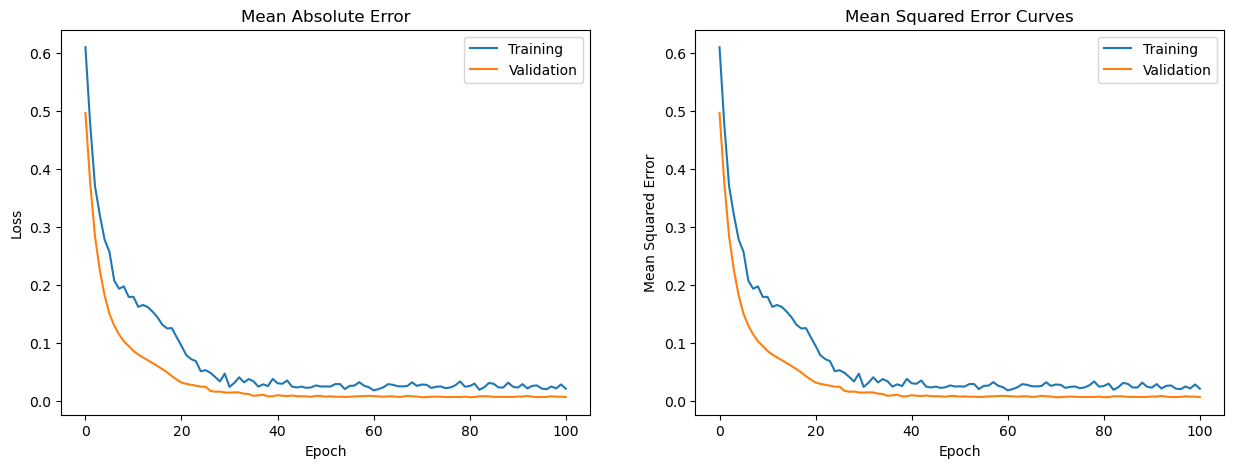

In [75]:
plot_model_history(tf_model.history)

2/2 [==============================] - 0s 6ms/step


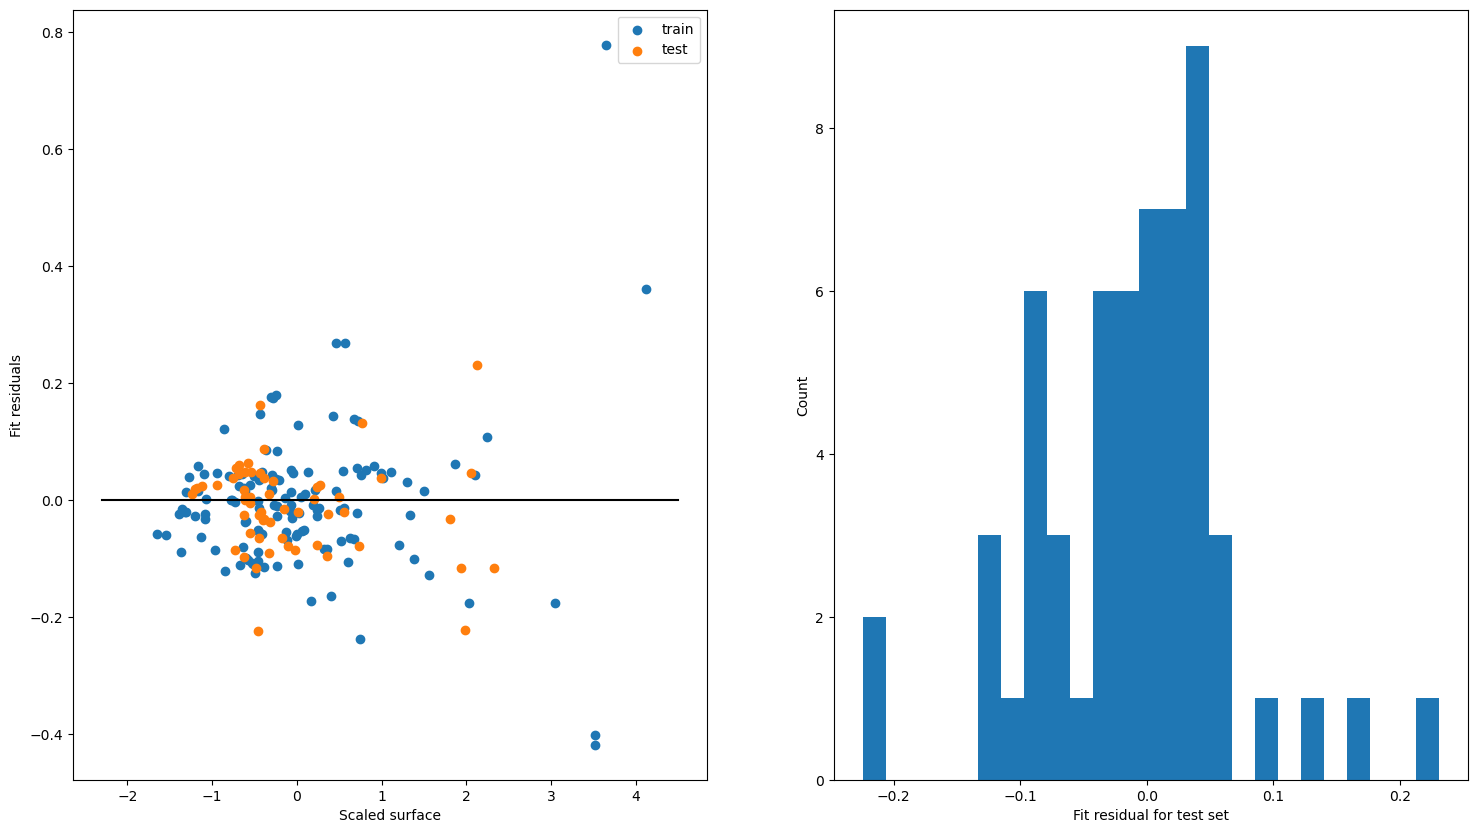

mean residuals: -0.01 
std: 0.08


In [76]:
plot_residue(tf_model, X, y_scaled, rs=rs)

2/2 [==============================] - 0s 6ms/step


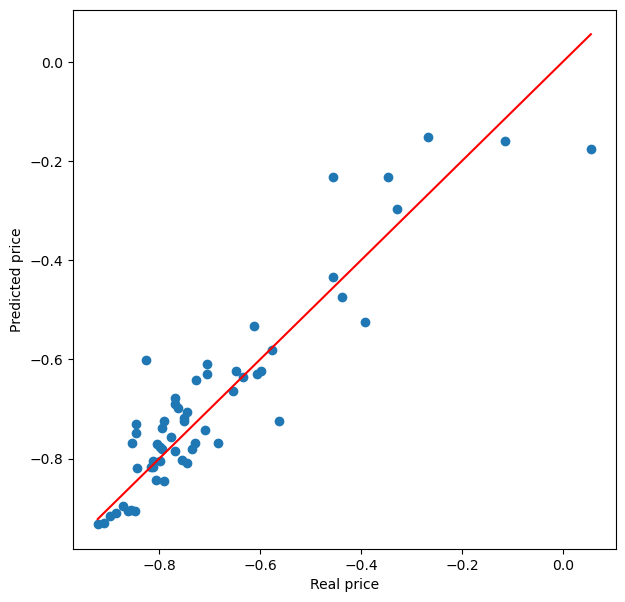

In [77]:
plot_real_pred(tf_model, X, y_scaled, rs=rs)

In [78]:
y_train_pred = tf_model.predict(X_train)
y_test_pred = tf_model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


### Scores with scaled prices

In [79]:
# R squared errors
print(" r2_train=", r2_score(y_train, y_train_pred),
      "\n r2_test=", r2_score(y_test, y_test_pred))

 r2_train= 0.8162563313798363 
 r2_test= 0.8419801142903542


In [80]:
# Mean Squared Error
print(" mse_train=", mean_squared_error(y_train, y_train_pred),
      "\n mse_test=", mean_squared_error(y_test, y_test_pred))

 mse_train= 0.014888917204162692 
 mse_test= 0.006110415961853967


In [81]:
# Mean Absolute Error
print(" mae_train=", mean_absolute_error(y_train, y_train_pred),
      "\n mae_test=", mean_absolute_error(y_test, y_test_pred))

 mae_train= 0.07645293869136863 
 mae_test= 0.05725205726981675


### Score with original prices

In [83]:
# Mean squared errors
print(' mse_train=', mean_squared_error(y2_price(y_train, R), y2_price(y_train_pred, R)),
      "\n mse_test=", mean_squared_error(y2_price(y_test, R), y2_price(y_test_pred, R)))

 mse_train= 7.431028552656809 
 mse_test= 3.049696018091039


In [84]:
# Mean Absolute Error
print(' mae_train=', mean_absolute_error(y2_price(y_train, R), y2_price(y_train_pred, R)),
      "\n mae_test=", mean_absolute_error(y2_price(y_test, R), y2_price(y_test_pred, R)))

 mae_train= 1.707996866355265 
 mae_test= 1.2790395734721214
